In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformal_map import *

%matplotlib inline

In [2]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
averageNumberHits = particles['nhits'].mean()
#hits.head()
#cells.head()
particles.head()
#truth.head()
print("Average number of hits is:", averageNumberHits)

Average number of hits is: 8.42412134061812


In [3]:
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]

In [4]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


Track with: 10 number of points
0.27873349400284436


c:\python36\lib\site-packages\ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


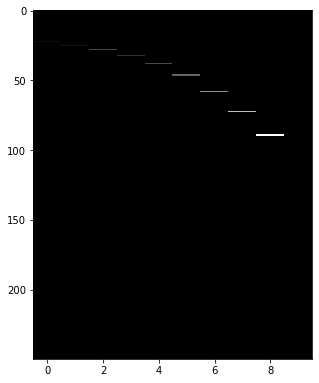

In [164]:
plt.figure(figsize=(5,20))
track = validTracks[1000]
numberBins = 250
accumulator = np.empty((numberBins, 0))
trackPoints = selected_truth[selected_truth.particle_id == track]
print("Track with:", len(trackPoints), "number of points")
for volume in [8, 13, 17]:
    for layer in hits[hits.volume_id == volume].layer_id.unique():
        truthVol8 = truth.iloc[hits.index[(hits.volume_id == volume)].tolist()]
        hitsVol8 = hits.iloc[hits.index[(hits.volume_id == volume)].tolist()]
        currentTrackPoints = truthVol8.loc[(hitsVol8.layer_id == layer) & (truthVol8.particle_id == track)]
        x = currentTrackPoints.tx
        y = currentTrackPoints.ty
        denom = np.power(x, 2) + np.power(y, 2)
        x = x/denom
        y = y/denom
        z = currentTrackPoints.tz
        r = np.power(x, 2) + np.power(y, 2)
        theta = np.arctan(y / x)
        thetaRange = np.pi
        indicesFloat = (theta / thetaRange) * numberBins + numberBins / 2
        indices = np.array(list(map(int, indicesFloat)))
        indices = np.reshape(indices, (len(indices), 1))
        bins = np.zeros((numberBins, 1))
        #print(indices)
        for i, index in enumerate(indices):
            bins[index, 0] += -z.iloc[i]
        accumulator = np.hstack([accumulator, bins])

        
t = selected_truth[selected_truth.particle_id == track]
px = t['tpx'].mean()
py = t['tpy'].mean()
pz = t['tpz'].mean()
p = np.sqrt(px**2 + py**2 + pz**2)
print(p)
plt.imshow(accumulator, cmap='gray')
plt.axes().set_aspect(0.05)

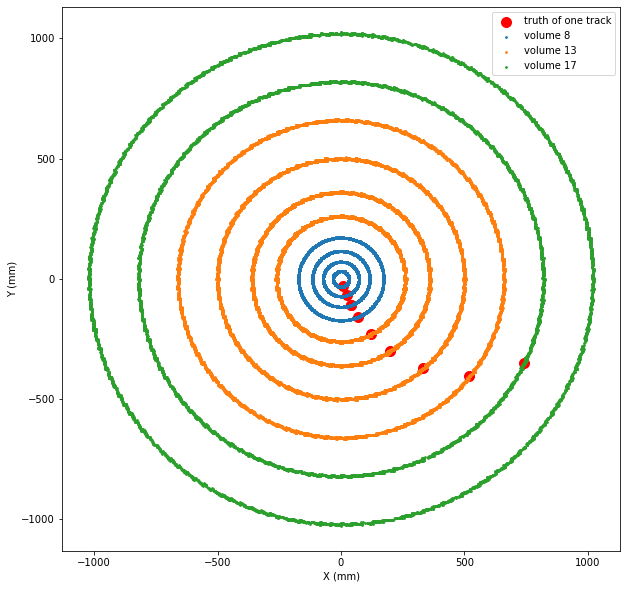

In [165]:
plt.figure(figsize=(10,10))
plt.scatter(trackPoints.tx, trackPoints.ty, color=["red"], s=100, label='truth of one track')
for volume in [8, 13, 17]:
    v = hits[hits.volume_id == volume]
    plt.scatter(v.x, v.y, s=3, label='volume {}'.format(volume))
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.show()

In [7]:
# Create training set with tracks that are minimum of 5 hits
tracks = selected_truth.particle_id.unique()
validTracks = []
for track in tracks:
    numberHits = selected_truth[selected_truth.particle_id == track].shape[0]
    if numberHits >= 5:
        validTracks.append(track)

print("Valid tracks:", len(validTracks), ", Total:", len(tracks))

Valid tracks: 5046 , Total: 8188


In [194]:
images = []
nr = len(validTracks)
for j, track in enumerate(validTracks[0:nr]):
    if track == 0:
        continue
    print(j, "/", len(validTracks))
    numberBins = 250
    accumulator = np.empty((numberBins, 0))
    trackPoints = selected_truth[selected_truth.particle_id == track]
    print("Track with:", len(trackPoints), "number of points")
    for volume in [8, 13, 17]:
        for layer in hits[hits.volume_id == volume].layer_id.unique():
            truthVol8 = truth.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            hitsVol8 = hits.iloc[hits.index[(hits.volume_id == volume)].tolist()]
            currentTrackPoints = truthVol8.loc[(hitsVol8.layer_id == layer) & (truthVol8.particle_id == track)]
            x = currentTrackPoints.tx
            y = currentTrackPoints.ty
            denom = np.power(x, 2) + np.power(y, 2)
            x = x/denom
            y = y/denom
            z = currentTrackPoints.tz
            r = np.power(x, 2) + np.power(y, 2)
            theta = np.arctan(y / x)
            thetaRange = np.pi
            indicesFloat = (theta / thetaRange) * numberBins + numberBins / 2
            indices = np.array(list(map(int, indicesFloat)))
            indices = np.reshape(indices, (len(indices), 1))
            bins = np.zeros((numberBins, 1))
            #print(indices)
            for i, index in enumerate(indices):
                bins[index, 0] += 1#-z.iloc[i]
            accumulator = np.hstack([accumulator, bins])
    images.append(accumulator)


1 / 5046
Track with: 8 number of points
2 / 5046
Track with: 12 number of points
3 / 5046
Track with: 8 number of points
4 / 5046
Track with: 10 number of points
5 / 5046
Track with: 5 number of points
6 / 5046
Track with: 9 number of points
7 / 5046
Track with: 10 number of points
8 / 5046
Track with: 8 number of points
9 / 5046
Track with: 11 number of points
10 / 5046
Track with: 5 number of points
11 / 5046
Track with: 14 number of points
12 / 5046
Track with: 8 number of points
13 / 5046
Track with: 13 number of points
14 / 5046
Track with: 7 number of points
15 / 5046
Track with: 8 number of points
16 / 5046
Track with: 9 number of points
17 / 5046
Track with: 6 number of points
18 / 5046
Track with: 8 number of points
19 / 5046
Track with: 7 number of points
20 / 5046
Track with: 11 number of points
21 / 5046
Track with: 8 number of points
22 / 5046
Track with: 11 number of points
23 / 5046
Track with: 9 number of points
24 / 5046
Track with: 11 number of points
25 / 5046
Track 

198 / 5046
Track with: 8 number of points
199 / 5046
Track with: 6 number of points
200 / 5046
Track with: 5 number of points
201 / 5046
Track with: 7 number of points
202 / 5046
Track with: 10 number of points
203 / 5046
Track with: 5 number of points
204 / 5046
Track with: 7 number of points
205 / 5046
Track with: 7 number of points
206 / 5046
Track with: 5 number of points
207 / 5046
Track with: 6 number of points
208 / 5046
Track with: 9 number of points
209 / 5046
Track with: 6 number of points
210 / 5046
Track with: 6 number of points
211 / 5046
Track with: 7 number of points
212 / 5046
Track with: 6 number of points
213 / 5046
Track with: 6 number of points
214 / 5046
Track with: 7 number of points
215 / 5046
Track with: 6 number of points
216 / 5046
Track with: 7 number of points
217 / 5046
Track with: 5 number of points
218 / 5046
Track with: 6 number of points
219 / 5046
Track with: 5 number of points
220 / 5046
Track with: 5 number of points
221 / 5046
Track with: 5 number o

395 / 5046
Track with: 7 number of points
396 / 5046
Track with: 8 number of points
397 / 5046
Track with: 7 number of points
398 / 5046
Track with: 7 number of points
399 / 5046
Track with: 8 number of points
400 / 5046
Track with: 6 number of points
401 / 5046
Track with: 5 number of points
402 / 5046
Track with: 6 number of points
403 / 5046
Track with: 9 number of points
404 / 5046
Track with: 5 number of points
405 / 5046
Track with: 7 number of points
406 / 5046
Track with: 6 number of points
407 / 5046
Track with: 5 number of points
408 / 5046
Track with: 5 number of points
409 / 5046
Track with: 9 number of points
410 / 5046
Track with: 9 number of points
411 / 5046
Track with: 8 number of points
412 / 5046
Track with: 8 number of points
413 / 5046
Track with: 5 number of points
414 / 5046
Track with: 8 number of points
415 / 5046
Track with: 5 number of points
416 / 5046
Track with: 7 number of points
417 / 5046
Track with: 7 number of points
418 / 5046
Track with: 8 number of

592 / 5046
Track with: 12 number of points
593 / 5046
Track with: 9 number of points
594 / 5046
Track with: 8 number of points
595 / 5046
Track with: 10 number of points
596 / 5046
Track with: 11 number of points
597 / 5046
Track with: 14 number of points
598 / 5046
Track with: 8 number of points
599 / 5046
Track with: 8 number of points
600 / 5046
Track with: 15 number of points
601 / 5046
Track with: 10 number of points
602 / 5046
Track with: 14 number of points
603 / 5046
Track with: 11 number of points
604 / 5046
Track with: 13 number of points
605 / 5046
Track with: 13 number of points
606 / 5046
Track with: 11 number of points
607 / 5046
Track with: 12 number of points
608 / 5046
Track with: 14 number of points
609 / 5046
Track with: 9 number of points
610 / 5046
Track with: 8 number of points
611 / 5046
Track with: 11 number of points
612 / 5046
Track with: 8 number of points
613 / 5046
Track with: 10 number of points
614 / 5046
Track with: 13 number of points
615 / 5046
Track w

785 / 5046
Track with: 7 number of points
786 / 5046
Track with: 9 number of points
787 / 5046
Track with: 9 number of points
788 / 5046
Track with: 6 number of points
789 / 5046
Track with: 10 number of points
790 / 5046
Track with: 11 number of points
791 / 5046
Track with: 5 number of points
792 / 5046
Track with: 11 number of points
793 / 5046
Track with: 6 number of points
794 / 5046
Track with: 9 number of points
795 / 5046
Track with: 13 number of points
796 / 5046
Track with: 8 number of points
797 / 5046
Track with: 10 number of points
798 / 5046
Track with: 9 number of points
799 / 5046
Track with: 12 number of points
800 / 5046
Track with: 11 number of points
801 / 5046
Track with: 5 number of points
802 / 5046
Track with: 11 number of points
803 / 5046
Track with: 13 number of points
804 / 5046
Track with: 11 number of points
805 / 5046
Track with: 12 number of points
806 / 5046
Track with: 10 number of points
807 / 5046
Track with: 8 number of points
808 / 5046
Track with:

980 / 5046
Track with: 5 number of points
981 / 5046
Track with: 7 number of points
982 / 5046
Track with: 12 number of points
983 / 5046
Track with: 12 number of points
984 / 5046
Track with: 13 number of points
985 / 5046
Track with: 11 number of points
986 / 5046
Track with: 10 number of points
987 / 5046
Track with: 10 number of points
988 / 5046
Track with: 9 number of points
989 / 5046
Track with: 11 number of points
990 / 5046
Track with: 7 number of points
991 / 5046
Track with: 7 number of points
992 / 5046
Track with: 9 number of points
993 / 5046
Track with: 10 number of points
994 / 5046
Track with: 11 number of points
995 / 5046
Track with: 9 number of points
996 / 5046
Track with: 16 number of points
997 / 5046
Track with: 12 number of points
998 / 5046
Track with: 14 number of points
999 / 5046
Track with: 12 number of points
1000 / 5046
Track with: 10 number of points
1001 / 5046
Track with: 5 number of points
1002 / 5046
Track with: 14 number of points
1003 / 5046
Trac

1169 / 5046
Track with: 10 number of points
1170 / 5046
Track with: 13 number of points
1171 / 5046
Track with: 13 number of points
1172 / 5046
Track with: 11 number of points
1173 / 5046
Track with: 11 number of points
1174 / 5046
Track with: 11 number of points
1175 / 5046
Track with: 9 number of points
1176 / 5046
Track with: 10 number of points
1177 / 5046
Track with: 11 number of points
1178 / 5046
Track with: 8 number of points
1179 / 5046
Track with: 8 number of points
1180 / 5046
Track with: 9 number of points
1181 / 5046
Track with: 8 number of points
1182 / 5046
Track with: 10 number of points
1183 / 5046
Track with: 9 number of points
1184 / 5046
Track with: 12 number of points
1185 / 5046
Track with: 12 number of points
1186 / 5046
Track with: 9 number of points
1187 / 5046
Track with: 11 number of points
1188 / 5046
Track with: 8 number of points
1189 / 5046
Track with: 12 number of points
1190 / 5046
Track with: 10 number of points
1191 / 5046
Track with: 13 number of poi

1358 / 5046
Track with: 8 number of points
1359 / 5046
Track with: 10 number of points
1360 / 5046
Track with: 13 number of points
1361 / 5046
Track with: 10 number of points
1362 / 5046
Track with: 12 number of points
1363 / 5046
Track with: 9 number of points
1364 / 5046
Track with: 13 number of points
1365 / 5046
Track with: 12 number of points
1366 / 5046
Track with: 8 number of points
1367 / 5046
Track with: 7 number of points
1368 / 5046
Track with: 8 number of points
1369 / 5046
Track with: 8 number of points
1370 / 5046
Track with: 11 number of points
1371 / 5046
Track with: 11 number of points
1372 / 5046
Track with: 9 number of points
1373 / 5046
Track with: 14 number of points
1374 / 5046
Track with: 10 number of points
1375 / 5046
Track with: 8 number of points
1376 / 5046
Track with: 11 number of points
1377 / 5046
Track with: 10 number of points
1378 / 5046
Track with: 9 number of points
1379 / 5046
Track with: 11 number of points
1380 / 5046
Track with: 11 number of poin

1547 / 5046
Track with: 11 number of points
1548 / 5046
Track with: 10 number of points
1549 / 5046
Track with: 12 number of points
1550 / 5046
Track with: 10 number of points
1551 / 5046
Track with: 10 number of points
1552 / 5046
Track with: 8 number of points
1553 / 5046
Track with: 14 number of points
1554 / 5046
Track with: 7 number of points
1555 / 5046
Track with: 13 number of points
1556 / 5046
Track with: 12 number of points
1557 / 5046
Track with: 8 number of points
1558 / 5046
Track with: 13 number of points
1559 / 5046
Track with: 12 number of points
1560 / 5046
Track with: 9 number of points
1561 / 5046
Track with: 7 number of points
1562 / 5046
Track with: 15 number of points
1563 / 5046
Track with: 12 number of points
1564 / 5046
Track with: 12 number of points
1565 / 5046
Track with: 12 number of points
1566 / 5046
Track with: 8 number of points
1567 / 5046
Track with: 11 number of points
1568 / 5046
Track with: 12 number of points
1569 / 5046
Track with: 9 number of po

1735 / 5046
Track with: 12 number of points
1736 / 5046
Track with: 10 number of points
1737 / 5046
Track with: 13 number of points
1738 / 5046
Track with: 10 number of points
1739 / 5046
Track with: 9 number of points
1740 / 5046
Track with: 10 number of points
1741 / 5046
Track with: 12 number of points
1742 / 5046
Track with: 11 number of points
1743 / 5046
Track with: 10 number of points
1744 / 5046
Track with: 11 number of points
1745 / 5046
Track with: 8 number of points
1746 / 5046
Track with: 11 number of points
1747 / 5046
Track with: 8 number of points
1748 / 5046
Track with: 12 number of points
1749 / 5046
Track with: 8 number of points
1750 / 5046
Track with: 5 number of points
1751 / 5046
Track with: 8 number of points
1752 / 5046
Track with: 5 number of points
1753 / 5046
Track with: 10 number of points
1754 / 5046
Track with: 11 number of points
1755 / 5046
Track with: 11 number of points
1756 / 5046
Track with: 14 number of points
1757 / 5046
Track with: 7 number of poi

1924 / 5046
Track with: 5 number of points
1925 / 5046
Track with: 12 number of points
1926 / 5046
Track with: 9 number of points
1927 / 5046
Track with: 6 number of points
1928 / 5046
Track with: 8 number of points
1929 / 5046
Track with: 7 number of points
1930 / 5046
Track with: 8 number of points
1931 / 5046
Track with: 11 number of points
1932 / 5046
Track with: 12 number of points
1933 / 5046
Track with: 13 number of points
1934 / 5046
Track with: 12 number of points
1935 / 5046
Track with: 8 number of points
1936 / 5046
Track with: 8 number of points
1937 / 5046
Track with: 12 number of points
1938 / 5046
Track with: 12 number of points
1939 / 5046
Track with: 7 number of points
1940 / 5046
Track with: 11 number of points
1941 / 5046
Track with: 9 number of points
1942 / 5046
Track with: 8 number of points
1943 / 5046
Track with: 10 number of points
1944 / 5046
Track with: 14 number of points
1945 / 5046
Track with: 13 number of points
1946 / 5046
Track with: 10 number of points

2113 / 5046
Track with: 15 number of points
2114 / 5046
Track with: 11 number of points
2115 / 5046
Track with: 10 number of points
2116 / 5046
Track with: 13 number of points
2117 / 5046
Track with: 11 number of points
2118 / 5046
Track with: 15 number of points
2119 / 5046
Track with: 14 number of points
2120 / 5046
Track with: 11 number of points
2121 / 5046
Track with: 6 number of points
2122 / 5046
Track with: 12 number of points
2123 / 5046
Track with: 8 number of points
2124 / 5046
Track with: 14 number of points
2125 / 5046
Track with: 13 number of points
2126 / 5046
Track with: 7 number of points
2127 / 5046
Track with: 7 number of points
2128 / 5046
Track with: 13 number of points
2129 / 5046
Track with: 8 number of points
2130 / 5046
Track with: 9 number of points
2131 / 5046
Track with: 11 number of points
2132 / 5046
Track with: 10 number of points
2133 / 5046
Track with: 10 number of points
2134 / 5046
Track with: 9 number of points
2135 / 5046
Track with: 12 number of po

2302 / 5046
Track with: 9 number of points
2303 / 5046
Track with: 10 number of points
2304 / 5046
Track with: 10 number of points
2305 / 5046
Track with: 10 number of points
2306 / 5046
Track with: 8 number of points
2307 / 5046
Track with: 7 number of points
2308 / 5046
Track with: 13 number of points
2309 / 5046
Track with: 11 number of points
2310 / 5046
Track with: 12 number of points
2311 / 5046
Track with: 12 number of points
2312 / 5046
Track with: 11 number of points
2313 / 5046
Track with: 12 number of points
2314 / 5046
Track with: 5 number of points
2315 / 5046
Track with: 6 number of points
2316 / 5046
Track with: 6 number of points
2317 / 5046
Track with: 10 number of points
2318 / 5046
Track with: 12 number of points
2319 / 5046
Track with: 17 number of points
2320 / 5046
Track with: 10 number of points
2321 / 5046
Track with: 10 number of points
2322 / 5046
Track with: 12 number of points
2323 / 5046
Track with: 12 number of points
2324 / 5046
Track with: 11 number of p

2491 / 5046
Track with: 11 number of points
2492 / 5046
Track with: 9 number of points
2493 / 5046
Track with: 13 number of points
2494 / 5046
Track with: 6 number of points
2495 / 5046
Track with: 7 number of points
2496 / 5046
Track with: 12 number of points
2497 / 5046
Track with: 8 number of points
2498 / 5046
Track with: 11 number of points
2499 / 5046
Track with: 11 number of points
2500 / 5046
Track with: 9 number of points
2501 / 5046
Track with: 8 number of points
2502 / 5046
Track with: 7 number of points
2503 / 5046
Track with: 5 number of points
2504 / 5046
Track with: 11 number of points
2505 / 5046
Track with: 10 number of points
2506 / 5046
Track with: 12 number of points
2507 / 5046
Track with: 10 number of points
2508 / 5046
Track with: 11 number of points
2509 / 5046
Track with: 8 number of points
2510 / 5046
Track with: 13 number of points
2511 / 5046
Track with: 8 number of points
2512 / 5046
Track with: 6 number of points
2513 / 5046
Track with: 12 number of points

2680 / 5046
Track with: 10 number of points
2681 / 5046
Track with: 10 number of points
2682 / 5046
Track with: 15 number of points
2683 / 5046
Track with: 9 number of points
2684 / 5046
Track with: 10 number of points
2685 / 5046
Track with: 10 number of points
2686 / 5046
Track with: 7 number of points
2687 / 5046
Track with: 11 number of points
2688 / 5046
Track with: 10 number of points
2689 / 5046
Track with: 11 number of points
2690 / 5046
Track with: 11 number of points
2691 / 5046
Track with: 11 number of points
2692 / 5046
Track with: 11 number of points
2693 / 5046
Track with: 12 number of points
2694 / 5046
Track with: 6 number of points
2695 / 5046
Track with: 7 number of points
2696 / 5046
Track with: 14 number of points
2697 / 5046
Track with: 13 number of points
2698 / 5046
Track with: 10 number of points
2699 / 5046
Track with: 11 number of points
2700 / 5046
Track with: 13 number of points
2701 / 5046
Track with: 11 number of points
2702 / 5046
Track with: 8 number of 

2869 / 5046
Track with: 9 number of points
2870 / 5046
Track with: 9 number of points
2871 / 5046
Track with: 10 number of points
2872 / 5046
Track with: 9 number of points
2873 / 5046
Track with: 9 number of points
2874 / 5046
Track with: 8 number of points
2875 / 5046
Track with: 11 number of points
2876 / 5046
Track with: 12 number of points
2877 / 5046
Track with: 14 number of points
2878 / 5046
Track with: 9 number of points
2879 / 5046
Track with: 10 number of points
2880 / 5046
Track with: 11 number of points
2881 / 5046
Track with: 12 number of points
2882 / 5046
Track with: 14 number of points
2883 / 5046
Track with: 14 number of points
2884 / 5046
Track with: 10 number of points
2885 / 5046
Track with: 12 number of points
2886 / 5046
Track with: 10 number of points
2887 / 5046
Track with: 8 number of points
2888 / 5046
Track with: 9 number of points
2889 / 5046
Track with: 11 number of points
2890 / 5046
Track with: 5 number of points
2891 / 5046
Track with: 6 number of point

3060 / 5046
Track with: 7 number of points
3061 / 5046
Track with: 15 number of points
3062 / 5046
Track with: 8 number of points
3063 / 5046
Track with: 11 number of points
3064 / 5046
Track with: 6 number of points
3065 / 5046
Track with: 9 number of points
3066 / 5046
Track with: 10 number of points
3067 / 5046
Track with: 9 number of points
3068 / 5046
Track with: 12 number of points
3069 / 5046
Track with: 8 number of points
3070 / 5046
Track with: 16 number of points
3071 / 5046
Track with: 12 number of points
3072 / 5046
Track with: 10 number of points
3073 / 5046
Track with: 6 number of points
3074 / 5046
Track with: 12 number of points
3075 / 5046
Track with: 11 number of points
3076 / 5046
Track with: 12 number of points
3077 / 5046
Track with: 11 number of points
3078 / 5046
Track with: 7 number of points
3079 / 5046
Track with: 9 number of points
3080 / 5046
Track with: 9 number of points
3081 / 5046
Track with: 14 number of points
3082 / 5046
Track with: 9 number of points

3248 / 5046
Track with: 11 number of points
3249 / 5046
Track with: 8 number of points
3250 / 5046
Track with: 12 number of points
3251 / 5046
Track with: 11 number of points
3252 / 5046
Track with: 8 number of points
3253 / 5046
Track with: 12 number of points
3254 / 5046
Track with: 12 number of points
3255 / 5046
Track with: 9 number of points
3256 / 5046
Track with: 13 number of points
3257 / 5046
Track with: 10 number of points
3258 / 5046
Track with: 5 number of points
3259 / 5046
Track with: 15 number of points
3260 / 5046
Track with: 6 number of points
3261 / 5046
Track with: 8 number of points
3262 / 5046
Track with: 9 number of points
3263 / 5046
Track with: 12 number of points
3264 / 5046
Track with: 13 number of points
3265 / 5046
Track with: 12 number of points
3266 / 5046
Track with: 10 number of points
3267 / 5046
Track with: 7 number of points
3268 / 5046
Track with: 12 number of points
3269 / 5046
Track with: 8 number of points
3270 / 5046
Track with: 10 number of poin

3436 / 5046
Track with: 12 number of points
3437 / 5046
Track with: 9 number of points
3438 / 5046
Track with: 12 number of points
3439 / 5046
Track with: 8 number of points
3440 / 5046
Track with: 8 number of points
3441 / 5046
Track with: 9 number of points
3442 / 5046
Track with: 9 number of points
3443 / 5046
Track with: 12 number of points
3444 / 5046
Track with: 10 number of points
3445 / 5046
Track with: 9 number of points
3446 / 5046
Track with: 12 number of points
3447 / 5046
Track with: 6 number of points
3448 / 5046
Track with: 13 number of points
3449 / 5046
Track with: 10 number of points
3450 / 5046
Track with: 12 number of points
3451 / 5046
Track with: 5 number of points
3452 / 5046
Track with: 7 number of points
3453 / 5046
Track with: 14 number of points
3454 / 5046
Track with: 5 number of points
3455 / 5046
Track with: 5 number of points
3456 / 5046
Track with: 12 number of points
3457 / 5046
Track with: 9 number of points
3458 / 5046
Track with: 9 number of points
3

3625 / 5046
Track with: 9 number of points
3626 / 5046
Track with: 5 number of points
3627 / 5046
Track with: 8 number of points
3628 / 5046
Track with: 9 number of points
3629 / 5046
Track with: 10 number of points
3630 / 5046
Track with: 5 number of points
3631 / 5046
Track with: 9 number of points
3632 / 5046
Track with: 7 number of points
3633 / 5046
Track with: 12 number of points
3634 / 5046
Track with: 9 number of points
3635 / 5046
Track with: 9 number of points
3636 / 5046
Track with: 11 number of points
3637 / 5046
Track with: 6 number of points
3638 / 5046
Track with: 10 number of points
3639 / 5046
Track with: 11 number of points
3640 / 5046
Track with: 11 number of points
3641 / 5046
Track with: 10 number of points
3642 / 5046
Track with: 8 number of points
3643 / 5046
Track with: 8 number of points
3644 / 5046
Track with: 8 number of points
3645 / 5046
Track with: 12 number of points
3646 / 5046
Track with: 10 number of points
3647 / 5046
Track with: 8 number of points
36

3817 / 5046
Track with: 5 number of points
3818 / 5046
Track with: 8 number of points
3819 / 5046
Track with: 9 number of points
3820 / 5046
Track with: 5 number of points
3821 / 5046
Track with: 9 number of points
3822 / 5046
Track with: 6 number of points
3823 / 5046
Track with: 7 number of points
3824 / 5046
Track with: 5 number of points
3825 / 5046
Track with: 5 number of points
3826 / 5046
Track with: 6 number of points
3827 / 5046
Track with: 8 number of points
3828 / 5046
Track with: 7 number of points
3829 / 5046
Track with: 5 number of points
3830 / 5046
Track with: 7 number of points
3831 / 5046
Track with: 5 number of points
3832 / 5046
Track with: 5 number of points
3833 / 5046
Track with: 6 number of points
3834 / 5046
Track with: 5 number of points
3835 / 5046
Track with: 6 number of points
3836 / 5046
Track with: 8 number of points
3837 / 5046
Track with: 9 number of points
3838 / 5046
Track with: 8 number of points
3839 / 5046
Track with: 6 number of points
3840 / 5046

4008 / 5046
Track with: 7 number of points
4009 / 5046
Track with: 7 number of points
4010 / 5046
Track with: 8 number of points
4011 / 5046
Track with: 6 number of points
4012 / 5046
Track with: 8 number of points
4013 / 5046
Track with: 6 number of points
4014 / 5046
Track with: 6 number of points
4015 / 5046
Track with: 5 number of points
4016 / 5046
Track with: 7 number of points
4017 / 5046
Track with: 9 number of points
4018 / 5046
Track with: 13 number of points
4019 / 5046
Track with: 7 number of points
4020 / 5046
Track with: 5 number of points
4021 / 5046
Track with: 8 number of points
4022 / 5046
Track with: 6 number of points
4023 / 5046
Track with: 8 number of points
4024 / 5046
Track with: 9 number of points
4025 / 5046
Track with: 5 number of points
4026 / 5046
Track with: 5 number of points
4027 / 5046
Track with: 7 number of points
4028 / 5046
Track with: 7 number of points
4029 / 5046
Track with: 5 number of points
4030 / 5046
Track with: 5 number of points
4031 / 504

4200 / 5046
Track with: 9 number of points
4201 / 5046
Track with: 10 number of points
4202 / 5046
Track with: 6 number of points
4203 / 5046
Track with: 5 number of points
4204 / 5046
Track with: 10 number of points
4205 / 5046
Track with: 5 number of points
4206 / 5046
Track with: 9 number of points
4207 / 5046
Track with: 13 number of points
4208 / 5046
Track with: 14 number of points
4209 / 5046
Track with: 9 number of points
4210 / 5046
Track with: 8 number of points
4211 / 5046
Track with: 10 number of points
4212 / 5046
Track with: 10 number of points
4213 / 5046
Track with: 13 number of points
4214 / 5046
Track with: 7 number of points
4215 / 5046
Track with: 5 number of points
4216 / 5046
Track with: 10 number of points
4217 / 5046
Track with: 10 number of points
4218 / 5046
Track with: 11 number of points
4219 / 5046
Track with: 11 number of points
4220 / 5046
Track with: 9 number of points
4221 / 5046
Track with: 14 number of points
4222 / 5046
Track with: 5 number of points

4391 / 5046
Track with: 10 number of points
4392 / 5046
Track with: 10 number of points
4393 / 5046
Track with: 8 number of points
4394 / 5046
Track with: 11 number of points
4395 / 5046
Track with: 7 number of points
4396 / 5046
Track with: 9 number of points
4397 / 5046
Track with: 9 number of points
4398 / 5046
Track with: 9 number of points
4399 / 5046
Track with: 7 number of points
4400 / 5046
Track with: 10 number of points
4401 / 5046
Track with: 10 number of points
4402 / 5046
Track with: 5 number of points
4403 / 5046
Track with: 8 number of points
4404 / 5046
Track with: 12 number of points
4405 / 5046
Track with: 8 number of points
4406 / 5046
Track with: 8 number of points
4407 / 5046
Track with: 5 number of points
4408 / 5046
Track with: 6 number of points
4409 / 5046
Track with: 6 number of points
4410 / 5046
Track with: 11 number of points
4411 / 5046
Track with: 12 number of points
4412 / 5046
Track with: 13 number of points
4413 / 5046
Track with: 7 number of points
44

4582 / 5046
Track with: 9 number of points
4583 / 5046
Track with: 8 number of points
4584 / 5046
Track with: 7 number of points
4585 / 5046
Track with: 9 number of points
4586 / 5046
Track with: 8 number of points
4587 / 5046
Track with: 8 number of points
4588 / 5046
Track with: 6 number of points
4589 / 5046
Track with: 11 number of points
4590 / 5046
Track with: 9 number of points
4591 / 5046
Track with: 9 number of points
4592 / 5046
Track with: 6 number of points
4593 / 5046
Track with: 9 number of points
4594 / 5046
Track with: 6 number of points
4595 / 5046
Track with: 6 number of points
4596 / 5046
Track with: 11 number of points
4597 / 5046
Track with: 5 number of points
4598 / 5046
Track with: 9 number of points
4599 / 5046
Track with: 7 number of points
4600 / 5046
Track with: 9 number of points
4601 / 5046
Track with: 7 number of points
4602 / 5046
Track with: 7 number of points
4603 / 5046
Track with: 7 number of points
4604 / 5046
Track with: 6 number of points
4605 / 50

4775 / 5046
Track with: 10 number of points
4776 / 5046
Track with: 6 number of points
4777 / 5046
Track with: 10 number of points
4778 / 5046
Track with: 5 number of points
4779 / 5046
Track with: 7 number of points
4780 / 5046
Track with: 10 number of points
4781 / 5046
Track with: 8 number of points
4782 / 5046
Track with: 6 number of points
4783 / 5046
Track with: 9 number of points
4784 / 5046
Track with: 6 number of points
4785 / 5046
Track with: 5 number of points
4786 / 5046
Track with: 8 number of points
4787 / 5046
Track with: 6 number of points
4788 / 5046
Track with: 9 number of points
4789 / 5046
Track with: 10 number of points
4790 / 5046
Track with: 7 number of points
4791 / 5046
Track with: 9 number of points
4792 / 5046
Track with: 6 number of points
4793 / 5046
Track with: 5 number of points
4794 / 5046
Track with: 7 number of points
4795 / 5046
Track with: 8 number of points
4796 / 5046
Track with: 6 number of points
4797 / 5046
Track with: 6 number of points
4798 / 

4967 / 5046
Track with: 8 number of points
4968 / 5046
Track with: 5 number of points
4969 / 5046
Track with: 6 number of points
4970 / 5046
Track with: 7 number of points
4971 / 5046
Track with: 8 number of points
4972 / 5046
Track with: 5 number of points
4973 / 5046
Track with: 5 number of points
4974 / 5046
Track with: 9 number of points
4975 / 5046
Track with: 8 number of points
4976 / 5046
Track with: 5 number of points
4977 / 5046
Track with: 6 number of points
4978 / 5046
Track with: 5 number of points
4979 / 5046
Track with: 7 number of points
4980 / 5046
Track with: 5 number of points
4981 / 5046
Track with: 6 number of points
4982 / 5046
Track with: 5 number of points
4983 / 5046
Track with: 6 number of points
4984 / 5046
Track with: 8 number of points
4985 / 5046
Track with: 6 number of points
4986 / 5046
Track with: 5 number of points
4987 / 5046
Track with: 6 number of points
4988 / 5046
Track with: 6 number of points
4989 / 5046
Track with: 6 number of points
4990 / 5046

In [195]:
# Create train_Y (the momentum)
train_y = np.empty((0, 1))
for j, track in enumerate(validTracks[0:nr]):
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    px = t['tpx'].mean()
    py = t['tpy'].mean()
    pz = t['tpz'].mean()
    p = np.sqrt(px**2 + py**2 + pz**2)
    train_y = np.append(train_y, [p])
train_y = np.reshape(train_y, (len(train_y), 1))
print(train_y.shape)

(5045, 1)


In [196]:
#train_X = np.reshape(images, (len(images), 500, 10, 1))
print(len(images))
train_X = np.reshape(images, (nr-1, 250, 10, 1))
print(train_X.shape)

5045
(5045, 250, 10, 1)


(250, 10)


c:\python36\lib\site-packages\ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


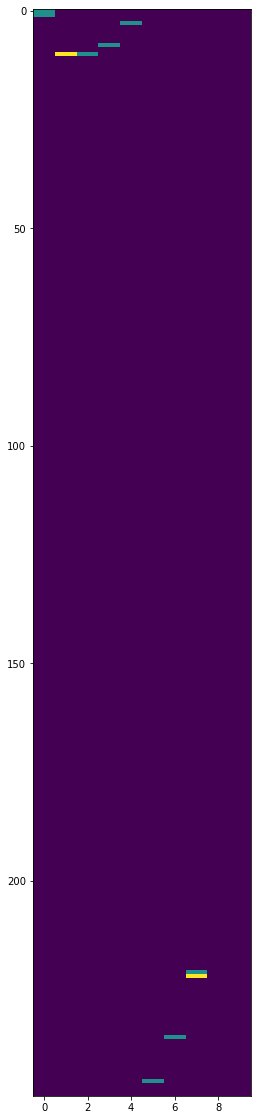

In [197]:
plt.figure(figsize=(5,20))
plt.imshow(images[36])
plt.axes().set_aspect(0.2)
print(images[32].shape)

In [198]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import layers

In [199]:
def build_model():
    model = keras.Sequential([
        layers.Conv2D(8, (3, 3), activation="relu", input_shape=(250, 10, 1)),
        #layers.Conv2D(8, (3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        #layers.Conv2D(8, (3, 3), activation="relu"),
        layers.Conv2D(16, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(1)
    ])

    #optimizer = keras.optimizers.RMSprop(learning_rate=0.00001) #0.00001 works good
    model.compile(loss='mse', optimizer='adam')
    return model

In [200]:
model = build_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 248, 8, 8)         80        
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 124, 4, 8)         0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 122, 2, 16)        1168      
_________________________________________________________________
flatten_14 (Flatten)         (None, 3904)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3905      
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [201]:
EPOCHS = 1000
print(train_X.shape)
print(train_y.shape)
history = model.fit(train_X, train_y, validation_split=0.1, epochs=EPOCHS)

(5045, 250, 10, 1)
(5045, 1)
Train on 4540 samples, validate on 505 samples
Epoch 1/1000
4540/4540 [==============================] - 1s 308us/step - loss: 6.4651 - val_loss: 1.1397
Epoch 2/1000
4540/4540 [==============================] - 1s 293us/step - loss: 5.9198 - val_loss: 0.9132
Epoch 3/1000
4540/4540 [==============================] - 1s 293us/step - loss: 5.3835 - val_loss: 1.0680
Epoch 4/1000
4540/4540 [==============================] - 1s 289us/step - loss: 5.1819 - val_loss: 3.2946
Epoch 5/1000
4540/4540 [==============================] - 1s 290us/step - loss: 5.0266 - val_loss: 4.7717
Epoch 6/1000
4540/4540 [==============================] - 1s 292us/step - loss: 4.8708 - val_loss: 6.7409
Epoch 7/1000
4540/4540 [==============================] - 1s 294us/step - loss: 4.8055 - val_loss: 5.3898
Epoch 8/1000
4540/4540 [==============================] - 1s 290us/step - loss: 4.5998 - val_loss: 6.9772
Epoch 9/1000
4540/4540 [==============================] - 1s 292us/step - lo

Epoch 77/1000
4540/4540 [==============================] - 1s 306us/step - loss: 0.4025 - val_loss: 3.1249
Epoch 78/1000
4540/4540 [==============================] - 1s 290us/step - loss: 0.3783 - val_loss: 3.4962
Epoch 79/1000
4540/4540 [==============================] - 1s 297us/step - loss: 0.3666 - val_loss: 3.1105
Epoch 80/1000
4540/4540 [==============================] - 2s 367us/step - loss: 0.3626 - val_loss: 3.2950
Epoch 81/1000
4540/4540 [==============================] - 1s 312us/step - loss: 0.3646 - val_loss: 3.3020
Epoch 82/1000
4540/4540 [==============================] - 1s 304us/step - loss: 0.3516 - val_loss: 3.4937
Epoch 83/1000
4540/4540 [==============================] - 1s 298us/step - loss: 0.3344 - val_loss: 3.2416
Epoch 84/1000
4540/4540 [==============================] - 1s 297us/step - loss: 0.3287 - val_loss: 2.8846
Epoch 85/1000
4540/4540 [==============================] - 1s 295us/step - loss: 0.3168 - val_loss: 3.0206
Epoch 86/1000
4540/4540 [============

4540/4540 [==============================] - 2s 336us/step - loss: 0.1221 - val_loss: 2.2308
Epoch 154/1000
4540/4540 [==============================] - 1s 301us/step - loss: 0.1372 - val_loss: 2.0793
Epoch 155/1000
4540/4540 [==============================] - 1s 299us/step - loss: 0.1276 - val_loss: 2.4100
Epoch 156/1000
4540/4540 [==============================] - 1s 298us/step - loss: 0.1219 - val_loss: 2.3810
Epoch 157/1000
4540/4540 [==============================] - 1s 310us/step - loss: 0.1218 - val_loss: 2.2284
Epoch 158/1000
4540/4540 [==============================] - 1s 300us/step - loss: 0.1189 - val_loss: 2.3719
Epoch 159/1000
4540/4540 [==============================] - 1s 289us/step - loss: 0.1137 - val_loss: 2.4429
Epoch 160/1000
4540/4540 [==============================] - 1s 291us/step - loss: 0.1167 - val_loss: 2.3110
Epoch 161/1000
4540/4540 [==============================] - 1s 292us/step - loss: 0.1138 - val_loss: 2.2024
Epoch 162/1000
4540/4540 [=================

Epoch 229/1000
4540/4540 [==============================] - 1s 294us/step - loss: 0.0764 - val_loss: 2.2252
Epoch 230/1000
4540/4540 [==============================] - 1s 300us/step - loss: 0.0713 - val_loss: 2.1426
Epoch 231/1000
4540/4540 [==============================] - 1s 295us/step - loss: 0.0721 - val_loss: 2.1828
Epoch 232/1000
4540/4540 [==============================] - 1s 297us/step - loss: 0.0802 - val_loss: 1.9312
Epoch 233/1000
4540/4540 [==============================] - 1s 293us/step - loss: 0.0789 - val_loss: 2.2574
Epoch 234/1000
4540/4540 [==============================] - 1s 300us/step - loss: 0.0773 - val_loss: 2.1720
Epoch 235/1000
4540/4540 [==============================] - 1s 292us/step - loss: 0.0800 - val_loss: 2.0611
Epoch 236/1000
4540/4540 [==============================] - 1s 295us/step - loss: 0.0743 - val_loss: 2.1365
Epoch 237/1000
4540/4540 [==============================] - 1s 300us/step - loss: 0.0770 - val_loss: 2.1325
Epoch 238/1000
4540/4540 [==

Epoch 305/1000
4540/4540 [==============================] - 1s 309us/step - loss: 0.0616 - val_loss: 2.0934
Epoch 306/1000
4540/4540 [==============================] - 2s 341us/step - loss: 0.0559 - val_loss: 1.9627
Epoch 307/1000
4540/4540 [==============================] - 1s 307us/step - loss: 0.0581 - val_loss: 2.1458
Epoch 308/1000
4540/4540 [==============================] - 1s 305us/step - loss: 0.0575 - val_loss: 2.0153
Epoch 309/1000
4540/4540 [==============================] - 2s 351us/step - loss: 0.0584 - val_loss: 1.9840
Epoch 310/1000
4540/4540 [==============================] - 1s 312us/step - loss: 0.0726 - val_loss: 1.9430
Epoch 311/1000
4540/4540 [==============================] - 1s 309us/step - loss: 0.0712 - val_loss: 1.9566
Epoch 312/1000
4540/4540 [==============================] - 1s 322us/step - loss: 0.0573 - val_loss: 1.8887
Epoch 313/1000
4540/4540 [==============================] - 2s 336us/step - loss: 0.0544 - val_loss: 2.0369
Epoch 314/1000
4540/4540 [==

Epoch 381/1000
4540/4540 [==============================] - 2s 338us/step - loss: 0.0514 - val_loss: 2.0368
Epoch 382/1000
4540/4540 [==============================] - 1s 326us/step - loss: 0.0545 - val_loss: 1.9817
Epoch 383/1000
4540/4540 [==============================] - 1s 305us/step - loss: 0.0792 - val_loss: 2.0231
Epoch 384/1000
4540/4540 [==============================] - 1s 307us/step - loss: 0.0554 - val_loss: 1.9016
Epoch 385/1000
4540/4540 [==============================] - 1s 313us/step - loss: 0.0517 - val_loss: 2.0109
Epoch 386/1000
4540/4540 [==============================] - 1s 307us/step - loss: 0.0440 - val_loss: 2.0378
Epoch 387/1000
4540/4540 [==============================] - 1s 310us/step - loss: 0.0429 - val_loss: 2.0198
Epoch 388/1000
4540/4540 [==============================] - 1s 303us/step - loss: 0.0425 - val_loss: 2.0841
Epoch 389/1000
4540/4540 [==============================] - 2s 337us/step - loss: 0.0407 - val_loss: 2.1361
Epoch 390/1000
4540/4540 [==

Epoch 457/1000
4540/4540 [==============================] - 1s 292us/step - loss: 0.0402 - val_loss: 2.1817
Epoch 458/1000
4540/4540 [==============================] - 1s 322us/step - loss: 0.0420 - val_loss: 2.1688
Epoch 459/1000
4540/4540 [==============================] - 1s 301us/step - loss: 0.0457 - val_loss: 2.0665
Epoch 460/1000
4540/4540 [==============================] - 1s 298us/step - loss: 0.0468 - val_loss: 1.9260
Epoch 461/1000
4540/4540 [==============================] - 1s 305us/step - loss: 0.0421 - val_loss: 2.0459
Epoch 462/1000
4540/4540 [==============================] - 2s 346us/step - loss: 0.0400 - val_loss: 2.1223
Epoch 463/1000
4540/4540 [==============================] - 2s 344us/step - loss: 0.0360 - val_loss: 2.1218
Epoch 464/1000
4540/4540 [==============================] - 1s 308us/step - loss: 0.0401 - val_loss: 2.1714
Epoch 465/1000
4540/4540 [==============================] - 1s 294us/step - loss: 0.0384 - val_loss: 2.2035
Epoch 466/1000
4540/4540 [==

Epoch 533/1000
4540/4540 [==============================] - 1s 301us/step - loss: 0.0372 - val_loss: 2.1847
Epoch 534/1000
4540/4540 [==============================] - 1s 316us/step - loss: 0.0428 - val_loss: 2.2953
Epoch 535/1000
4540/4540 [==============================] - 1s 313us/step - loss: 0.0432 - val_loss: 2.1252
Epoch 536/1000
4540/4540 [==============================] - 1s 316us/step - loss: 0.0429 - val_loss: 2.1172
Epoch 537/1000
4540/4540 [==============================] - 1s 299us/step - loss: 0.0427 - val_loss: 2.0971
Epoch 538/1000
4540/4540 [==============================] - 1s 298us/step - loss: 0.0387 - val_loss: 2.2727
Epoch 539/1000
4540/4540 [==============================] - 1s 296us/step - loss: 0.0332 - val_loss: 2.1763
Epoch 540/1000
4540/4540 [==============================] - 1s 296us/step - loss: 0.0360 - val_loss: 2.1017
Epoch 541/1000
4540/4540 [==============================] - 1s 302us/step - loss: 0.0355 - val_loss: 2.1791
Epoch 542/1000
4540/4540 [==

KeyboardInterrupt: 

In [204]:
i = 1205
prediction = model.predict(np.reshape(images[i], (1, 250, 10, 1)))
print(prediction, " ", train_y[i])

[[0.9027641]]   [0.77902762]
